## Detecção de obstrução em válvulas de máquinas de LC por análise de séries temporais
### IFES - PPCOMP - Mestrado em Computação Aplicada

**Notebook**: Extração de características v0.3

Periodo preliminar de análise: 01/2019 e 02/2019 (2 meses)
*****
**Datasets** (40+ Séries Temporais em intervalos de 10/10 segundos)

**Fonte:** PIMS - Aspentech IP.21 - Banco de Dados Temporal de Processo
+ formated_Output-LC2_20191.txt (Janeiro/2019)
+ formated_Output-LC2_20192.txt (Fevereiro/2019)
+ intervalos_candidatos.txt (datas apontadas pela operação com incidência de obstrução)
*****
Este Notebook tem por objetivo a extração de carcterísticas de um conjunto de sinais temporais que podem ser representativos para a identificação de anomalias no processo de lingotamento contínuo e consequente identificação do problema de obustrução (*clogging*). 

A proposta é de que seja feita uma extração em janelas deslizantes de 5 minutos discretizando o intervalo em características que representem os fenômenos ocorridos no processo, fazendo uso do pacote Python [TSFRESH](https://tsfresh.readthedocs.io/en/latest/#).

*TSFRESH - "Time Series Feature extraction based on scalable hypothesis tests"*
>tsfresh is a python package. It automatically calculates a large number of time series characteristics, the so called features. Further the package contains methods to evaluate the explaining power and importance of such characteristics for regression or classification tasks.

A abordagem a ser utilizada na sequência para identificação será o uso de uma técnica de aprendizado de máquina não supervisionada, neste caso agrupamento (clustering) sobre os datasets gerados pela discretização das séries.


In [25]:
# Bibliotecas Python em uso no projeto

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import glob
from sklearn.preprocessing import StandardScaler,RobustScaler,Normalizer,MinMaxScaler
import tsfresh as tsf
from tsfresh import extract_features
from tsfresh.feature_extraction import MinimalFCParameters,EfficientFCParameters

#### Séries de interesse para análise de obstrução

**Controle de Abertura de Válvula**: 
*Representa a % de abertura da valvula gaveta durante o processo de lingotamento*

| TAG (Sinal) | Descrição |
| ------ | ------ |
| LC2.K_SLDGT_STR3A_AL_POS | % de abertura de valvula - veio 3|
| LC2.L_SLDGT_STR4A_AL_POS | % de abertura de valvula - veio 4|

**Fluxo de Argônio**:
*Sofre "asceleração" nos casos de entupimento das válvulas*

| TAG (Sinal) | Descrição |
| ------ | ------ |
| LC2.FT_671_3_F, LC2.FT_681_3_F| Fluxo de Argonio - carro 3 |
| LC2.FT_671_4_G, LC2.FT_681_4_G| Fluxo de Argonio - carro 4|


In [96]:
# Tags de interesse para análise de obstrução
TAGList=['LC2.K_SLDGT_STR3A_AL_POS' # valvula gaveta veio 3
         ,'LC2.L_SLDGT_STR4A_AL_POS' # valvula gaveta veio 4
         ,'LC2.e_VEL_REAL_G1_A2' # veloc. veio 3
         ,'LC2.e_VEL_REAL_G1_B2' # veloc. veio 4
         ,'LC2.K_MLD_LVL_NKK_3A'
         ,'LC2.L_MLD_LVL_NKK_4A'
         ,'LC2.C_TD_CAR_WGHT_A'
         ,'LC2.FT_671_3_F'
         ,'LC2.FT_673_3_F'
         ,'LC2.FT_671_4_G'
         ,'LC2.FT_673_4_G'
         ,'LC2.FT_681_3_F'
         ,'LC2.FT_683_3_F'
         ,'LC2.FT_681_4_G'
         ,'LC2.FT_683_4_G'
         #,'LC2.PT_671_3_F','LC2.PT_671_4_G','LC2.PT_681_3_F','LC2.PT_681_4_G' # Variáveis de pressão removidas
        ]

TAGListVAL_v3=['LC2.K_SLDGT_STR3A_AL_POS']
TAGListVAL_v4=['LC2.L_SLDGT_STR4A_AL_POS']

TAGListSpd_v3=['LC2.e_VEL_REAL_G1_A2']
TAGListSpd_v4=['LC2.e_VEL_REAL_G1_B2']

TAGListNKK_v3=['LC2.K_MLD_LVL_NKK_3A']
TAGListNKK_v4=['LC2.L_MLD_LVL_NKK_4A']

TAGListAR_v3=[
          'LC2.FT_671_3_F'
         ,'LC2.FT_673_3_F'
         ,'LC2.FT_681_3_F'
         ,'LC2.FT_683_3_F'
        ]

TAGListAR_v4=[
          'LC2.FT_671_4_G'
         ,'LC2.FT_673_4_G'
         ,'LC2.FT_681_4_G'
         ,'LC2.FT_683_4_G'
        ]

TAGListWGHT=['LC2.C_TD_CAR_WGHT_A']

# Leitura do dataset (Todos os arquivos formated*.txt no diretorio /data)
               
path = r'./data'
all_files = glob.glob(path + "/formated_*.txt")
list_frames = []
for filename in all_files:
    print("Arquivo:",filename)
    frame = pd.read_csv(filename, index_col=0)
    list_frames.append(frame)
df_AllTags = pd.concat(list_frames, axis=0)
df_AllTags.index=pd.to_datetime(df_AllTags.index)
df_AllTags=df_AllTags.astype('float64')
df_AllTags = df_AllTags.loc[~df_AllTags.index.duplicated(keep='first')] # Eliminação de duplicatas - horario de verao
print("Total de linhas no Data Frame: ",len(df_AllTags))

Arquivo: ./data/formated_Output-LC2_20192.txt
Arquivo: ./data/formated_Output-LC2_20191.txt
Total de linhas no Data Frame:  509760


In [97]:
# Filtragem das Tags de interesse
df_tags=df_AllTags.loc[:, df_AllTags.columns.isin(TAGList)]
df=df_tags

In [98]:
# Verificacao de duplicatas
df.loc[df.index.duplicated()].index.unique()

DatetimeIndex([], dtype='datetime64[ns]', name='TIMESTAMP', freq=None)

In [99]:
df.head()

,LC2.C_TD_CAR_WGHT_A,LC2.e_VEL_REAL_G1_A2,LC2.e_VEL_REAL_G1_B2,LC2.FT_671_3_F,LC2.FT_671_4_G,LC2.FT_673_3_F,LC2.FT_673_4_G,LC2.FT_681_3_F,LC2.FT_681_4_G,LC2.FT_683_3_F,LC2.FT_683_4_G,LC2.K_MLD_LVL_NKK_3A,LC2.K_SLDGT_STR3A_AL_POS,LC2.L_MLD_LVL_NKK_4A,LC2.L_SLDGT_STR4A_AL_POS
TIMESTAMP,,,,,,,,,,,,,,,
2019-02-01 00:00:00,56.4552,1.1437,0.9983,10.0761,11.0,3.0,3.9288,4.1,3.0054,3.1,3.1,87.5916,33.3148,88.4226,42.5664
2019-02-01 00:00:10,56.4363,1.1436,0.9982,10.0763,11.0,3.0,3.9319,4.1,3.0056,3.1,3.1,87.2979,32.1074,86.0000,42.4000
2019-02-01 00:00:20,56.4174,1.1436,0.9980,10.0766,11.0,3.0,3.9350,4.1,3.0059,3.1,3.1,86.5028,31.8909,89.0000,42.8000
2019-02-01 00:00:30,56.3985,1.1435,0.9979,10.0769,11.0,3.0,3.9382,4.1,3.0062,3.1,3.1,89.5000,35.1000,87.6245,41.6095
2019-02-01 00:00:40,56.3796,1.1434,0.9978,10.0772,11.0,3.0,3.9413,4.1,3.0065,3.1,3.1,88.2552,33.9929,85.9192,39.9000


In [200]:
df.corr(method='spearman')

,LC2.C_TD_CAR_WGHT_A,LC2.e_VEL_REAL_G1_A2,LC2.e_VEL_REAL_G1_B2,LC2.FT_671_3_F,LC2.FT_671_4_G,LC2.FT_673_3_F,LC2.FT_673_4_G,LC2.FT_681_3_F,LC2.FT_681_4_G,LC2.FT_683_3_F,LC2.FT_683_4_G,LC2.K_MLD_LVL_NKK_3A,LC2.K_SLDGT_STR3A_AL_POS,LC2.L_MLD_LVL_NKK_4A,LC2.L_SLDGT_STR4A_AL_POS,id
LC2.C_TD_CAR_WGHT_A,1.000000,0.484346,0.486102,0.259212,0.298362,0.178583,0.162014,0.147242,0.148919,0.030869,0.066003,-0.353482,0.342575,-0.402727,0.376972,0.012588
LC2.e_VEL_REAL_G1_A2,0.484346,1.000000,0.742772,0.172870,0.198849,0.138885,0.103206,0.211145,0.206719,0.074603,0.112532,-0.339410,0.561623,-0.373196,0.497691,-0.000434
LC2.e_VEL_REAL_G1_B2,0.486102,0.742772,1.000000,0.178743,0.205913,0.162529,0.086114,0.196349,0.189004,0.073413,0.096979,-0.323794,0.448186,-0.375539,0.542602,-0.023440
LC2.FT_671_3_F,0.259212,0.172870,0.178743,1.000000,0.709434,0.495540,0.427975,-0.440992,-0.481814,-0.264686,-0.275972,-0.108958,0.201844,-0.128171,0.167407,-0.006004
LC2.FT_671_4_G,0.298362,0.198849,0.205913,0.709434,1.000000,0.409221,0.550952,-0.438199,-0.483526,-0.184664,-0.316901,-0.188776,0.141015,-0.210068,0.214844,-0.006861
LC2.FT_673_3_F,0.178583,0.138885,0.162529,0.495540,0.409221,1.000000,0.276749,-0.300881,-0.305744,-0.171065,-0.195031,-0.122232,0.170034,-0.123700,0.162178,-0.032901
LC2.FT_673_4_G,0.162014,0.103206,0.086114,0.427975,0.550952,0.276749,1.000000,-0.283962,-0.234394,-0.134108,-0.176415,-0.106341,0.113646,-0.120357,0.148187,0.000377
LC2.FT_681_3_F,0.147242,0.211145,0.196349,-0.440992,-0.438199,-0.300881,-0.283962,1.000000,0.739676,0.409528,0.493601,-0.199320,0.212037,-0.222210,0.199181,0.053274
LC2.FT_681_4_G,0.148919,0.206719,0.189004,-0.481814,-0.483526,-0.305744,-0.234394,0.739676,1.000000,0.252138,0.601459,-0.190303,0.177431,-0.215313,0.237820,0.071716
LC2.FT_683_3_F,0.030869,0.074603,0.073413,-0.264686,-0.184664,-0.171065,-0.134108,0.409528,0.252138,1.000000,0.235570,-0.065937,0.106957,-0.074061,0.065742,-0.033495


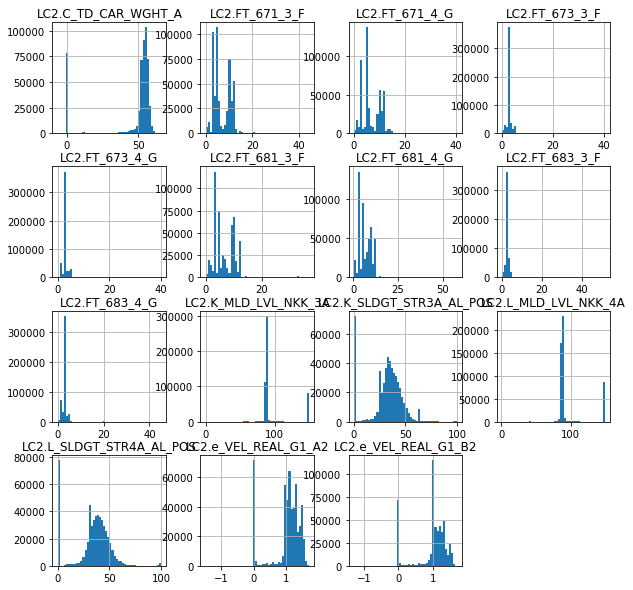

In [101]:
# Histograma do Dataframe

void=df.hist(bins=50,figsize=(10,10))

**Observação:** *Vale observar o comportamento normal das válvulas e a presença de um conjunto considerável em zero(%) o que representa situação de parada de processo e que deverão ser expurgadas a posteriori*

In [102]:
df.describe()

,LC2.C_TD_CAR_WGHT_A,LC2.e_VEL_REAL_G1_A2,LC2.e_VEL_REAL_G1_B2,LC2.FT_671_3_F,LC2.FT_671_4_G,LC2.FT_673_3_F,LC2.FT_673_4_G,LC2.FT_681_3_F,LC2.FT_681_4_G,LC2.FT_683_3_F,LC2.FT_683_4_G,LC2.K_MLD_LVL_NKK_3A,LC2.K_SLDGT_STR3A_AL_POS,LC2.L_MLD_LVL_NKK_4A,LC2.L_SLDGT_STR4A_AL_POS
count,509285.000000,509259.000000,509259.000000,509286.000000,509286.000000,509286.000000,509286.000000,509286.000000,509286.000000,509286.000000,509286.000000,509286.000000,509286.000000,509286.000000,509286.000000
mean,45.070104,1.012252,0.978299,6.763552,6.805877,2.994488,3.033263,6.679669,6.605592,3.028612,2.912631,97.406963,31.332872,98.117873,33.748091
std,20.205232,0.467519,0.452517,3.670239,3.801000,1.208428,1.680442,3.807928,3.563900,2.056386,1.374223,23.286065,15.473944,23.582082,17.182740
min,-6.589400,-1.485100,-1.290600,0.000000,0.037700,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.700000,0.000000
25%,51.207300,0.993200,0.989100,4.000000,4.000000,3.000000,2.996700,3.100000,3.100000,3.020900,3.039700,87.034525,26.000000,86.908100,29.946475
50%,53.903200,1.122600,1.085600,5.014800,5.010300,3.000000,3.000000,6.044550,5.100000,3.100000,3.100000,87.648800,33.995700,87.737300,37.073600
75%,55.675800,1.298000,1.269700,10.000000,10.000000,3.025300,3.031100,10.057200,10.032300,3.100000,3.100000,88.500000,40.964525,88.967175,44.210725
max,66.138600,1.705000,1.697800,44.250100,40.363000,40.360100,40.000000,37.051800,58.100000,51.736600,45.100000,150.000000,100.000000,150.000000,100.000000


##### Geração das "Janelas Deslizantes" - 5/5 minutos

+ inclusão de coluna de indexação das janelas no DataFrame **['id']**
+ inclusão de coluna **['time']** no DataFrame como réplica do indice temporal para ser usado no *TSFRESH*

In [103]:
window_size=300 # segundos
# strider_size= 240 # minutos

id_list=pd.DataFrame(columns=['id'],index=df_tags.index)
id_list['id']=list((pd.to_timedelta(pd.Series(df.index)).dt.total_seconds().astype(int))//window_size)
df_id=df_tags.copy().join(id_list)
df_id['time']=df_id.index
df=df_id

# Armazena as janelas geradas
df_id.to_csv('./data/ts_windows.csv')

In [104]:
### Eliminação de Janelas com "missing data"
df_id.dropna(inplace=True)

### Extração de Características - TSFresh

Uso do pacote Python [TSFRESH](https://tsfresh.readthedocs.io/en/latest/#).

Lista de características: [TSFRESH - *Features*](https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html)

+ Coluna de indexação das janelas: **['id']** *(Altera de 5 em 5 minutos)*
+ Coluna de ordenação das janelas: **['time']** *(Tempo de 10 em 10s)*

Apesar das válvulas dos 2 veios da máquina de lingotamento estarem correlacionadas (estão ligadas ao mesmo distribuidor de aço), optou-se durante análise exploratória em separar as características dos veios (veios 3 e 4) pois as dimensões combinadas estavam gerando "ruídos" no processo de separação dos clusters. 


In [21]:
# Features padrões
#settings=MinimalFCParameters() # (Min,Max,Std,Mean)
#settings=EfficientFCParameters()
#extracted_features=pd.DataFrame()
#extracted_features = extract_features(df_id, column_id="id", column_sort="time",default_fc_parameters=settings)

# Features customizadas para contexto de obstrução

# Parâmetros para análise do comportamento da válvula gaveta
fc_parameters = {
    "mean": None
    ,"standard_deviation": None
    ,"absolute_sum_of_changes":None
    ,"linear_trend":[{'attr': 'slope'}]
    ,"large_standard_deviation":[{'r': 0.5}]
    ,"longest_strike_above_mean":None
    ,"longest_strike_below_mean":None
    ,"mean_change":None
    ,"mean_second_derivative_central":None
    ,"median":None
    ,"sum_values":None
    ,"variance":None
    ,"minimum":None
    ,"maximum":None
    ,"variance_larger_than_standard_deviation":None
}

# Parâmetros complementares - válvula gaveta - análise da derivada
fc_parameters2 = {
    "count_above_mean":None
    ,"count_below_mean":None
    ,"variance_larger_than_standard_deviation":None
    ,"number_crossing_m":[{'m': 0}]
}

# Parâmetros para análise do comportamento do argonio e peso do carro distribuidor
fc_parameters3 = {
    "linear_trend":[{'attr': 'slope'}]
}

# Caracteristicas da valvula do veio 3
extracted_features_v3 = extract_features(df_id[TAGListVAL_v3+['id','time']], column_id="id", column_sort="time"
                                      ,default_fc_parameters=fc_parameters,disable_progressbar=False)

extracted_features_v3d = extract_features(df_id[['id','time']].join(df_id[TAGListVAL_v3].diff().fillna(0).add_suffix('_diff')), column_id="id", column_sort="time"
                                      ,default_fc_parameters=fc_parameters2,disable_progressbar=False)

# Caracteristicas da valvula do veio 4
extracted_features_v4 = extract_features(df_id[TAGListVAL_v4+['id','time']], column_id="id", column_sort="time"
                                      ,default_fc_parameters=fc_parameters,disable_progressbar=False)

extracted_features_v4d = extract_features(df_id[['id','time']].join(df_id[TAGListVAL_v4].diff().fillna(0).add_suffix('_diff')), column_id="id", column_sort="time"
                                      ,default_fc_parameters=fc_parameters2,disable_progressbar=False)


#Caracteristicas do Argonio do veio 3
extracted_features_ar_v3 = extract_features(df_id[TAGListAR_v3+['id','time']], column_id="id", column_sort="time"
                                      ,default_fc_parameters=fc_parameters3,disable_progressbar=False)

#Caracteristicas do Argonio do veio 4
extracted_features_ar_v4 = extract_features(df_id[TAGListAR_v4+['id','time']], column_id="id", column_sort="time"
                                      ,default_fc_parameters=fc_parameters3,disable_progressbar=False)

#Caracteristicas do peso do carro distribuidor.
extracted_features_wght = extract_features(df_id[TAGListWGHT+['id','time']], column_id="id", column_sort="time"
                                      ,default_fc_parameters=fc_parameters3,disable_progressbar=False)


Feature Extraction: 100%|██████████| 80/80 [00:08<00:00,  9.41it/s]


In [22]:
extracted_featuresV3 = extracted_features_v3.join(extracted_features_v3d).join(extracted_features_ar_v3).join(extracted_features_wght)
extracted_featuresV4 = extracted_features_v4.join(extracted_features_v4d).join(extracted_features_ar_v4).join(extracted_features_wght)
extracted_featuresV34 = extracted_features_v3.join(extracted_features_v3d).join(
                        extracted_features_v4).join(extracted_features_v4d).join(extracted_features_ar_v3).join(extracted_features_ar_v4).join(extracted_features_wght)

##### Característica Calculada
**MinMax** - Diferença entre máximos e mínimos nas janelas deslizantes

In [23]:
extracted_featuresV3.loc[:,'LC2.K_SLDGT_STR3A_AL_POS__minmax']=extracted_featuresV3['LC2.K_SLDGT_STR3A_AL_POS__maximum']-extracted_featuresV3['LC2.K_SLDGT_STR3A_AL_POS__minimum']
extracted_featuresV4.loc[:,'LC2.L_SLDGT_STR4A_AL_POS__minmax']=extracted_featuresV4['LC2.L_SLDGT_STR4A_AL_POS__maximum']-extracted_featuresV4['LC2.L_SLDGT_STR4A_AL_POS__minimum']

extracted_featuresV34.loc[:,'LC2.K_SLDGT_STR3A_AL_POS__minmax']=extracted_featuresV34['LC2.K_SLDGT_STR3A_AL_POS__maximum']-extracted_featuresV34['LC2.K_SLDGT_STR3A_AL_POS__minimum']
extracted_featuresV34.loc[:,'LC2.L_SLDGT_STR4A_AL_POS__minmax']=extracted_featuresV34['LC2.L_SLDGT_STR4A_AL_POS__maximum']-extracted_featuresV34['LC2.L_SLDGT_STR4A_AL_POS__minimum']

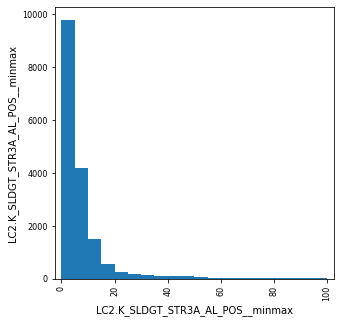

In [24]:
gr = pd.plotting.scatter_matrix(extracted_featuresV3.filter(regex='minmax',axis=1),  figsize=(5, 5), marker='o',
                                 hist_kwds={'bins': 20}, s=60, alpha=.8)

##### Característica Calculada 
Relação Velocidade da Máquina  vs Abertura de Valvula

In [265]:
idlist=df_id['id'].unique()

teste=3

w=df_id.loc[df_id.id==idlist[teste]][TAGListVAL_v3+TAGListSpd_v3]
scaler=StandardScaler()
dfid_s=pd.DataFrame(scaler.fit_transform(w),index=w.index,columns=w.columns)

dfid_s.corr(method='pearson')


,LC2.K_SLDGT_STR3A_AL_POS,LC2.e_VEL_REAL_G1_A2
LC2.K_SLDGT_STR3A_AL_POS,1.000000,0.708075
LC2.e_VEL_REAL_G1_A2,0.708075,1.000000


In [266]:
np.polyfit(w['LC2.K_SLDGT_STR3A_AL_POS'],w['LC2.e_VEL_REAL_G1_A2'],deg=1)

array([6.88376271e-04, 1.46734667e+00])

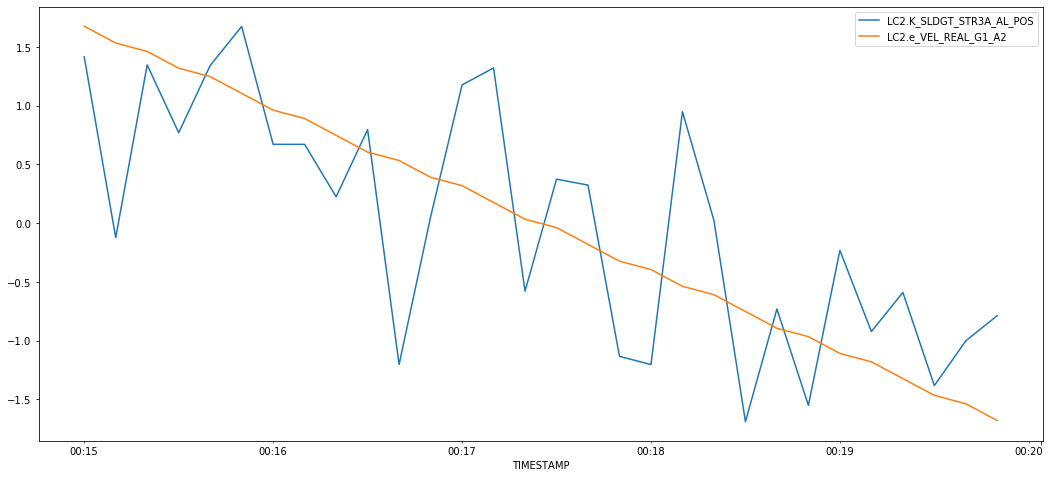

In [267]:
void=dfid_s.plot(figsize=(18,8))

##### Preparação do Dataset para o Veio 3

In [25]:
df=extracted_featuresV3

In [26]:
df.columns

Index(['LC2.K_SLDGT_STR3A_AL_POS__absolute_sum_of_changes',
       'LC2.K_SLDGT_STR3A_AL_POS__large_standard_deviation__r_0.5',
       'LC2.K_SLDGT_STR3A_AL_POS__linear_trend__attr_"slope"',
       'LC2.K_SLDGT_STR3A_AL_POS__longest_strike_above_mean',
       'LC2.K_SLDGT_STR3A_AL_POS__longest_strike_below_mean',
       'LC2.K_SLDGT_STR3A_AL_POS__maximum', 'LC2.K_SLDGT_STR3A_AL_POS__mean',
       'LC2.K_SLDGT_STR3A_AL_POS__mean_change',
       'LC2.K_SLDGT_STR3A_AL_POS__mean_second_derivative_central',
       'LC2.K_SLDGT_STR3A_AL_POS__median', 'LC2.K_SLDGT_STR3A_AL_POS__minimum',
       'LC2.K_SLDGT_STR3A_AL_POS__standard_deviation',
       'LC2.K_SLDGT_STR3A_AL_POS__sum_values',
       'LC2.K_SLDGT_STR3A_AL_POS__variance',
       'LC2.K_SLDGT_STR3A_AL_POS__variance_larger_than_standard_deviation',
       'LC2.K_SLDGT_STR3A_AL_POS_diff__count_above_mean',
       'LC2.K_SLDGT_STR3A_AL_POS_diff__count_below_mean',
       'LC2.K_SLDGT_STR3A_AL_POS_diff__number_crossing_m__m_0',
       'L

##### Filtros (Máscaras) 

In [27]:
# Janelas de parada no processo do DataFrame - desvio padrão da valvula tendendo a zero no intervalo da janela
mask1v3=(df['LC2.K_SLDGT_STR3A_AL_POS__standard_deviation']<0.1)

In [28]:
# Filtro de Slope - não utilizado
mask2v3 = ((df.filter(like='slope',axis=1).filter(regex='\.[P|F]T\_')>0.2)==False).T.all()==False

In [29]:
# Filtro para análise de diferenças entre máximos e mínimos de alta variabilidade (85%)
mask3v3=((df.filter(like='minmax',axis=1)>85)==False).T.all()==False

In [30]:
(df[~mask1v3&mask3v3].filter(regex='minmax|minimum', axis=1))

variable,LC2.K_SLDGT_STR3A_AL_POS__minimum,LC2.K_SLDGT_STR3A_AL_POS__minmax
id,,
5155256,0.0000,98.0000
5155369,0.0000,98.8548
5155375,0.0000,99.1000
5158091,0.0000,98.8118
5158285,0.0000,97.1000
5159271,0.0000,98.6361
5160210,0.0000,98.7000
5160332,0.0000,96.4836
5161811,0.0000,100.0000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9fa8e06828>]],
      dtype=object)

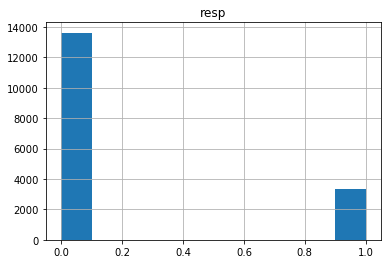

In [32]:
# Geracao de variaveis resposta para cenarios de "nao operacao"
# Para uso Futuro
y=pd.DataFrame(index=df.index)
y['resp']=0
y.loc[mask1v3,['resp']]=1
y.hist()

In [33]:
# Grava Dataset com as features do Veio 3 - Filtrando os intervalos de parada de processo 
df[~mask1v3].to_csv('./data/features_Strand3_new.csv')

##### Preparação do Dataset para o Veio 4
*Repetição do processo do Veio 3*

In [34]:
df=extracted_featuresV4

In [35]:
df.columns

Index(['LC2.L_SLDGT_STR4A_AL_POS__absolute_sum_of_changes',
       'LC2.L_SLDGT_STR4A_AL_POS__large_standard_deviation__r_0.5',
       'LC2.L_SLDGT_STR4A_AL_POS__linear_trend__attr_"slope"',
       'LC2.L_SLDGT_STR4A_AL_POS__longest_strike_above_mean',
       'LC2.L_SLDGT_STR4A_AL_POS__longest_strike_below_mean',
       'LC2.L_SLDGT_STR4A_AL_POS__maximum', 'LC2.L_SLDGT_STR4A_AL_POS__mean',
       'LC2.L_SLDGT_STR4A_AL_POS__mean_change',
       'LC2.L_SLDGT_STR4A_AL_POS__mean_second_derivative_central',
       'LC2.L_SLDGT_STR4A_AL_POS__median', 'LC2.L_SLDGT_STR4A_AL_POS__minimum',
       'LC2.L_SLDGT_STR4A_AL_POS__standard_deviation',
       'LC2.L_SLDGT_STR4A_AL_POS__sum_values',
       'LC2.L_SLDGT_STR4A_AL_POS__variance',
       'LC2.L_SLDGT_STR4A_AL_POS__variance_larger_than_standard_deviation',
       'LC2.L_SLDGT_STR4A_AL_POS_diff__count_above_mean',
       'LC2.L_SLDGT_STR4A_AL_POS_diff__count_below_mean',
       'LC2.L_SLDGT_STR4A_AL_POS_diff__number_crossing_m__m_0',
       'L

In [36]:
mask1v4=(df['LC2.L_SLDGT_STR4A_AL_POS__standard_deviation']<0.1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9fa8fc9320>]],
      dtype=object)

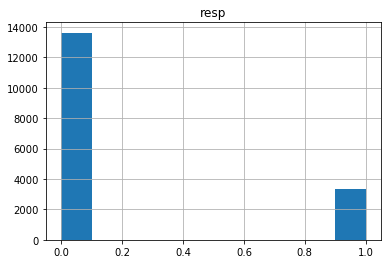

In [37]:
y=pd.DataFrame(index=df.index)
y['resp']=0
y.loc[mask1v4,['resp']]=1
y.hist()

In [38]:
df[~mask1v4].to_csv('./data/features_Strand4_new.csv')

##### Preparação do Dataset para o Veio 3 e 4 conjugados

In [28]:
df=extracted_featuresV34

In [29]:
extracted_featuresV34.head()

variable,LC2.K_SLDGT_STR3A_AL_POS__absolute_sum_of_changes,LC2.K_SLDGT_STR3A_AL_POS__large_standard_deviation__r_0.5,"LC2.K_SLDGT_STR3A_AL_POS__linear_trend__attr_""slope""",LC2.K_SLDGT_STR3A_AL_POS__longest_strike_above_mean,LC2.K_SLDGT_STR3A_AL_POS__longest_strike_below_mean,LC2.K_SLDGT_STR3A_AL_POS__maximum,LC2.K_SLDGT_STR3A_AL_POS__mean,LC2.K_SLDGT_STR3A_AL_POS__mean_change,LC2.K_SLDGT_STR3A_AL_POS__mean_second_derivative_central,LC2.K_SLDGT_STR3A_AL_POS__median,...,"LC2.FT_671_3_F__linear_trend__attr_""slope""","LC2.FT_673_3_F__linear_trend__attr_""slope""","LC2.FT_681_3_F__linear_trend__attr_""slope""","LC2.FT_683_3_F__linear_trend__attr_""slope""","LC2.FT_671_4_G__linear_trend__attr_""slope""","LC2.FT_673_4_G__linear_trend__attr_""slope""","LC2.FT_681_4_G__linear_trend__attr_""slope""","LC2.FT_683_4_G__linear_trend__attr_""slope""",LC2.K_SLDGT_STR3A_AL_POS__minmax,LC2.L_SLDGT_STR4A_AL_POS__minmax
id,,,,,,,,,,,,,,,,,,,,,
5154336,23.9157,0.0,-0.026096,8.0,5.0,42.7774,41.278540,-0.041162,0.009763,41.26390,...,0.0,0.0,-0.000556,-0.000278,0.0,0.0,0.001604,0.000278,3.6774,6.7593
5154337,27.3841,0.0,0.016003,3.0,3.0,42.8745,41.138870,0.011548,-0.032738,41.10845,...,0.0,0.0,-0.000556,-0.000278,0.0,0.0,0.001600,0.000278,4.0745,5.3903
5154338,30.9593,0.0,0.010740,3.0,5.0,43.4559,41.836457,0.011948,-0.003943,41.83035,...,0.0,0.0,-0.000555,-0.000278,0.0,0.0,0.001605,0.000278,3.2559,11.2539
5154339,24.0946,0.0,0.002156,5.0,5.0,43.0716,41.868233,0.065055,-0.011734,41.96130,...,0.0,0.0,-0.000556,-0.000278,0.0,0.0,-0.020225,0.000000,2.8716,18.7254
5154340,27.7816,0.0,-0.024659,3.0,3.0,43.1000,41.123410,0.014083,-0.009661,40.99510,...,0.0,0.0,-0.000556,-0.000278,0.0,0.0,-0.000278,0.000000,3.4000,6.2000


In [30]:
mask1v34=(df['LC2.K_SLDGT_STR3A_AL_POS__standard_deviation']<0.1)|(df['LC2.K_SLDGT_STR3A_AL_POS__standard_deviation']<0.1)

In [31]:
df[~mask1v34].to_csv('./data/features_Strand34_new.csv')

### Função de Visualização das Séries Temporais

**filter** : Recebe intervalo de interesse para visualização ('ids' das janela inicial e final do intervalo)

In [220]:
filter=range(5163269-3,5163269+1)
df_id.loc[df_id.id.isin(filter)][TAGList].head()

,LC2.K_SLDGT_STR3A_AL_POS,LC2.L_SLDGT_STR4A_AL_POS,LC2.e_VEL_REAL_G1_A2,LC2.e_VEL_REAL_G1_B2,LC2.K_MLD_LVL_NKK_3A,LC2.L_MLD_LVL_NKK_4A,LC2.C_TD_CAR_WGHT_A,LC2.FT_671_3_F,LC2.FT_673_3_F,LC2.FT_671_4_G,LC2.FT_673_4_G,LC2.FT_681_3_F,LC2.FT_683_3_F,LC2.FT_681_4_G,LC2.FT_683_4_G
TIMESTAMP,,,,,,,,,,,,,,,
2019-02-01 00:10:00,35.9289,44.4152,1.1395,0.9906,87.3521,88.4000,56.3492,10.0927,3.0240,11.0,4.1169,4.1,3.1,3.0220,3.1
2019-02-01 00:10:10,38.3000,42.8292,1.1394,0.9905,88.6242,86.7018,56.3524,10.0930,3.0248,11.0,4.1200,4.1,3.1,3.0223,3.1
2019-02-01 00:10:20,35.1076,42.5011,1.1393,0.9904,86.7076,86.5386,56.3556,10.0933,3.0257,11.0,4.1231,4.1,3.1,3.0226,3.1
2019-02-01 00:10:30,35.5297,42.7683,1.1393,0.9903,87.9621,88.0882,56.3588,10.0936,3.0266,11.0,4.1263,4.1,3.1,3.0229,3.1
2019-02-01 00:10:40,36.5882,44.7420,1.1392,0.9901,87.6852,86.7066,56.3620,10.0938,3.0275,11.0,4.1294,4.1,3.1,3.0231,3.1


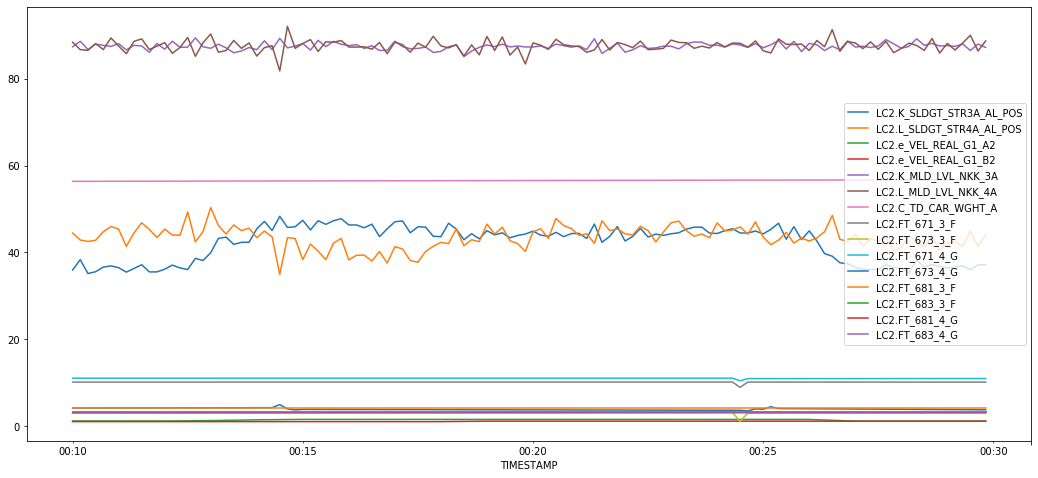

In [268]:
void=df_id.loc[df_id.id.isin(filter)][TAGList].plot(figsize=(18,8))